## SIIM ISIC MELANOMA DETECTION - Ensemble(Transfer) Learning

### Ensemble learning is the process by which multiple models, such as classifiers or experts, are strategically generated and combined to solve a particular computational intelligence problem. 

### I have trained the model using two transfer learning models VGG16 and Xception model here to predict whether images are Malignant or benign.

### You will also find code for DenseNet model in this notebook. I just didn't trained the model using Densenet because of time constraint(I trained it earlier but accidentally re run the notebook and it takes days to finish 30 epochs due to system processing speed) . So i removed the model fit  part for DenseNet but one can easily add it, train and validate the model for DenseNet as well. 

### If you have any doubts or need explaination, you can reach me at khurana.d@northeastern.edu


---------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np 
import pandas as pd 
import gc
import json
import math
import cv2
import PIL
from PIL import Image
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA

%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
print(os.listdir("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification"))

['x_test_96.npy', 'x_train_32.npy', '.DS_Store', 'test', 'x_train_128.npy', 'test.csv', 'x_train_96.npy', 'x_test_32.npy', 'x_test_128.npy', 'datasets_680899_1200702_x_train_64.npy', 'train', 'train.csv', 'jpeg', 'x_test_224.npy', 'x_test_64.npy', 'tfrecords', 'x_train_224.npy', 'sample_submission.csv']


In [3]:
#Loading Train and Test Data
train = pd.read_csv("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [4]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
np.mean(train.target)

0.01762965646320111

## So this is a binary classification problem with highly imbalanced data.

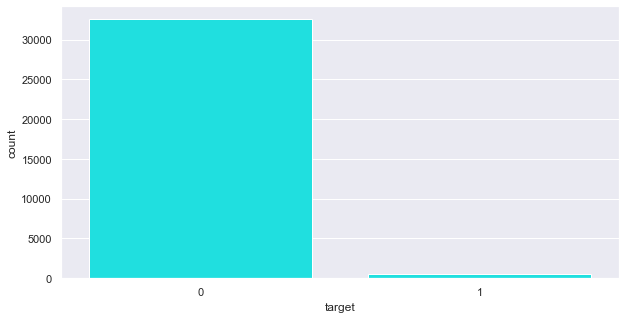

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x='target', data=train,
                   order=list(train['target'].value_counts().sort_index().index) ,
                   color='cyan')

In [8]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [9]:
train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

##  Target vs Sex Distribution

In [10]:
z=train.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds') 

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


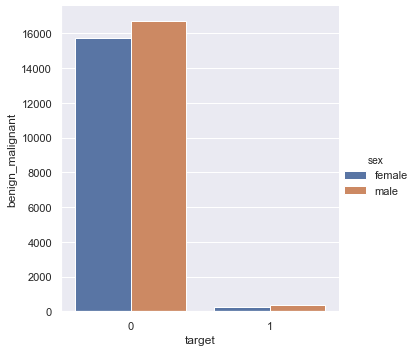

In [11]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')

### VISUALISING IMAGE DATA : JPEG

Display random images


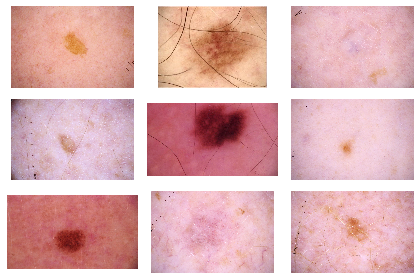

In [12]:
images= train['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display random images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

In [13]:
benign = train[train['benign_malignant']=='benign']
malignant = train[train['benign_malignant']=='malignant']

Display Benign images


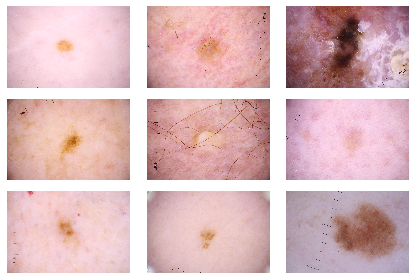

In [14]:
images= benign['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display Benign images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

Display Malignant images


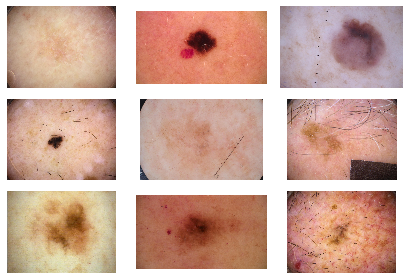

In [15]:
images= malignant['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display Malignant images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout() 

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Convolution2D,Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras import applications

### Training

In [17]:
import time 

In [18]:
start=time.time()
train_images = np.load('../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/x_train_96.npy')
end=time.time()
print(f"\nTime to load train images: {round(end-start,5)} seconds.")
print('Train_images shape: ',train_images.shape)


Time to load train images: 1.27617 seconds.
Train_images shape:  (33126, 96, 96, 3)


In [19]:
start=time.time()
test_images = np.load('../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/x_test_96.npy')
end=time.time()
print(f"\nTime to load test images: {round(end-start,5)} seconds.")
print('Test_images shape: ',test_images.shape)


Time to load test images: 0.25431 seconds.
Test_images shape:  (10982, 96, 96, 3)


In [20]:
#target data
train_labels =np.array(train.drop(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis','benign_malignant'],axis=1))
print('Train_labels shape: ',train_labels.shape)

Train_labels shape:  (33126, 1)


In [21]:
#spliting train data
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [22]:
print('x_train shape: ',x_train.shape)
print('x_val shape: ',x_val.shape)

x_train shape:  (23188, 96, 96, 3)
x_val shape:  (9938, 96, 96, 3)


## Data Augmentation

augs = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

augs.fit(x_train)

In [23]:
## Modelling

In [24]:
strategy = tf.distribute.get_strategy()

In [25]:
#VGG-16 MODEL NO. 1
from keras.applications.vgg16 import VGG16

input_shape=(96,96,3)
num_classes=1
tmodel_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
model = Sequential()
model.add(tmodel_base)
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid', name='output_layer'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [26]:
#XCEPTION MODEL NO. 2
from keras.layers import Dropout, DepthwiseConv2D, MaxPooling2D, concatenate
from keras.models import Model

inp = Input(shape = (96,96, 3))
x = inp
x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)

x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

x1 = Activation("relu")(x)
x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])


x = Activation("relu")(x)
x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

x = Dense(1, activation = "sigmoid")(x)


model2 = Model(inp, x)
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 48, 48, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 48, 48, 32)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [27]:
#DENSENET MODEL NO. 3
from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.layers as L

with strategy.scope():
    dnet201 = DenseNet201(
        input_shape=(96,96, 3),
        weights='imagenet',
        include_top=False
    )
    dnet201.trainable = True

    model3 = tf.keras.Sequential([
        dnet201,
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
    model3.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


In [28]:
batch_size=128
epochs=30

history = model.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

/Users/deepankkhurana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 23188 samples, validate on 9938 samples
Epoch 1/30
23188/23188 [==============================] - 2097s 90ms/step - loss: 0.5097 - accuracy: 0.7910 - val_loss: 0.2897 - val_accuracy: 0.9704
Epoch 2/30
23188/23188 [==============================] - 2514s 108ms/step - loss: 0.2192 - accuracy: 0.9672 - val_loss: 0.1623 - val_accuracy: 0.9807
Epoch 3/30
23188/23188 [==============================] - 3125s 135ms/step - loss: 0.1574 - accuracy: 0.9743 - val_loss: 0.2961 - val_accuracy: 0.9800
Epoch 4/30
23188/23188 [==============================] - 2097s 90ms/step - loss: 0.1427 - accuracy: 0.9726 - val_loss: 0.0947 - val_accuracy: 0.9810
Epoch 5/30
23188/23188 [==============================] - 2792s 120ms/step - loss: 0.1197 - accuracy: 0.9795 - val_loss: 0.1179 - val_accuracy: 0.9810
Epoch 6/30
23188/23188 [==============================] - 3265s 141ms/step - loss: 0.1078 - accuracy: 0.9806 - val_loss: 0.1054 - val_accuracy: 0.9810
Epoch 7/30
23188/23188 [=======================

In [29]:
batch_size=128
epochs=15

history3 = model2.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

/Users/deepankkhurana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 23188 samples, validate on 9938 samples
Epoch 1/15
23188/23188 [==============================] - 4538s 196ms/step - loss: 0.5349 - accuracy: 0.9630 - val_loss: 1.0898 - val_accuracy: 0.7234
Epoch 2/15
23188/23188 [==============================] - 10769s 464ms/step - loss: 0.6890 - accuracy: 0.9661 - val_loss: 6.8695 - val_accuracy: 0.7248
Epoch 3/15
23188/23188 [==============================] - 12385s 534ms/step - loss: 0.2972 - accuracy: 0.9706 - val_loss: 0.1738 - val_accuracy: 0.9809
Epoch 4/15
23188/23188 [==============================] - 5407s 233ms/step - loss: 0.1959 - accuracy: 0.9761 - val_loss: 1.4193 - val_accuracy: 0.9776
Epoch 5/15
23188/23188 [==============================] - 5935s 256ms/step - loss: 0.1515 - accuracy: 0.9792 - val_loss: 10.3971 - val_accuracy: 0.9774
Epoch 6/15
23188/23188 [==============================] - 37255s 2s/step - loss: 0.1781 - accuracy: 0.9796 - val_loss: 0.9389 - val_accuracy: 0.9784
Epoch 7/15
23188/23188 [====================

In [42]:
model.save("vgg16.h5")

In [33]:
model2.save("xception.h5")

### Evaluation

In [35]:
scores = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.10186915614818946
Test accuracy: 0.9813845753669739


In [36]:
scores = model2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.08904503240134035
Test accuracy: 0.9810827374458313


### Prediction

In [37]:
y_test_prob = model.predict(test_images)
pred_df = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob)})
pred_df.to_csv('submission_vgg.csv',header=True, index=False)
pred_df.head(10)

,image_name,target
0,ISIC_0052060,0.046400
1,ISIC_0052349,0.031370
2,ISIC_0058510,0.020848
3,ISIC_0073313,0.003402
4,ISIC_0073502,0.066036
5,ISIC_0074618,0.057583
6,ISIC_0076801,0.034758
7,ISIC_0077586,0.070604
8,ISIC_0082004,0.113256
9,ISIC_0082785,0.078652


In [38]:
y_test_prob2 = model2.predict(test_images)
pred_df2 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob2)})
pred_df2.to_csv('submission_xception.csv',header=True, index=False)
pred_df2.head(10)

,image_name,target
0,ISIC_0052060,3.077149e-03
1,ISIC_0052349,1.267940e-03
2,ISIC_0058510,1.127366e-07
3,ISIC_0073313,7.767033e-12
4,ISIC_0073502,1.109168e-02
5,ISIC_0074618,1.007664e-02
6,ISIC_0076801,9.849399e-03
7,ISIC_0077586,1.336640e-02
8,ISIC_0082004,1.938248e-02
9,ISIC_0082785,2.341178e-02


### Ensemble

In [39]:
en = pd.DataFrame({'image_name':test['image_name'], 'target':(0.3*pred_df['target'] + 0.3*pred_df2['target'])})
en.to_csv('ensemble1.csv',header=True, index=False)
en.head(10)

,image_name,target
0,ISIC_0052060,0.014843
1,ISIC_0052349,0.009791
2,ISIC_0058510,0.006254
3,ISIC_0073313,0.001021
4,ISIC_0073502,0.023138
5,ISIC_0074618,0.020298
6,ISIC_0076801,0.013382
7,ISIC_0077586,0.025191
8,ISIC_0082004,0.039792
9,ISIC_0082785,0.030619
